# Description
Goals : Melakukan prediksi terhadap suatu kalimat termasuk sentimen positive atau negative di suatu ulasan film.

Kita bisa menggunakan Long Short-Term Memory (LSTM) untuk menangani kasus tersebut karena
- Merupakan data berututan (teks ulasan film)
- Menangani urutan data, dengan "memori" dari data yang telah diproses sebelumnya
- Bisa menangani konteks kalimat secara keseluruhan.
- Bisa menghadapi Variasi Panjang Kalimat
- Cocok untuk tugas Klasifikasi Biner
- Bisa Pemrosesan Urutan Berbeda

Tahapan dari metode ini adalah

- Data Preparation
- Modeling
- Evaluation
- Prediction

In [2]:
# import package
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np

# Data Preparation
Data yang dipakai adalah 25,000 movies reviews dari IMDB, yang berlabe sentiment positive atau negative. Data ini data yang sudah disediakan oleh Tensorflow sendiri. Tahapan cleaning data 

- **Max_words** --> Membatasi jumlah kata --> Untuk mengurangi kompleksitas model dengan hanya mempertimbangkan kata-kata yang paling sering digunakan, yang akan mengurangi ukuran data dan mempercepat pelatihan.
- **Max_length** --> mengatur panjang maksimum urutan kata dalam setiap teks input --> Untuk menstandarisasi panjang input agar dapat diproses dalam batch, karena model neural network memerlukan input dengan panjang tetap.
- **Padding** --> berfungsi untuk memastikan bahwa semua input (urutan kata) yang dimasukkan ke dalam model memiliki panjang yang sama. 

In [4]:
# 1. Persiapkan Data
# Muat dataset IMDB (ulasan film)
max_words = 10000  # Batasi jumlah kata yang digunakan
maxlen = 200       # Panjang maksimum setiap ulasan (200 kata)

# Membagi data menjadi data latih dan data uji
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words)

# Padding data agar panjang input seragam
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

# Modeling

RNN cocok untuk analisis sentimen teks ini karena dapat menangani urutan data (kata-kata dalam kalimat) dan mempertahankan konteks serta hubungan antar kata dalam teks. Hal ini memungkinkan model untuk membuat prediksi sentimen yang lebih akurat dengan memahami makna keseluruhan teks, bukan hanya kata-kata individualnya. RNN bekerja dengan baik dalam menangani ketergantungan jangka panjang, yang sangat berguna dalam banyak tugas NLP, termasuk analisis sentimen.

Model ini mengguanakan
- Embedding Layer: Mewakili kata-kata sebagai vektor berdimensi 128.
- SimpleRNN Layer: Lapisan RNN untuk memproses urutan data, menggunakan 128 unit dan fungsi aktivasi tanh.
- Dropout Layer: Untuk mengurangi overfitting dengan menonaktifkan beberapa neuron secara acak selama pelatihan.
- Dense Layer: Output layer dengan 1 unit dan fungsi aktivasi sigmoid untuk klasifikasi biner (positif/negatif).
- Callback : EarlyStoppingAtMinLoss (memilih model dengan loss terendah)

In [6]:
# Bangun model LSTM
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=maxlen))
model.add(LSTM(128, activation='tanh', return_sequences=False))
model.add(Dense(1, activation='sigmoid'))  # Output layer untuk klasifikasi biner (sentimen positif/negatif)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [7]:
# 3. Kompilasi Model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

In [9]:
## 4. Train the model 
history = model.fit(
    x_train, 
    y_train, 
    epochs=5, 
    batch_size=64, 
    validation_data=(x_test, y_test), 
    verbose=1,
    callbacks=[EarlyStoppingAtMinLoss()]
)
     

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 81s 204ms/step - accuracy: 0.6885 - loss: 0.5707 - val_accuracy: 0.8651 - val_loss: 0.3283
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 209ms/step - accuracy: 0.8931 - loss: 0.2715 - val_accuracy: 0.8656 - val_loss: 0.3246
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 81s 206ms/step - accuracy: 0.9292 - loss: 0.1924 - val_accuracy: 0.8620 - val_loss: 0.3478
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 84s 216ms/step - accuracy: 0.9514 - loss: 0.1385 - val_accuracy: 0.8364 - val_loss: 0.3923
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 91s 232ms/step - accuracy: 0.9580 - loss: 0.1138 - val_accuracy: 0.8642 - val_loss: 0.4339


In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,235,141 (16.16 MB)

 Trainable params: 1,411,713 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,823,428 (10.77 MB)

# Evaluation
Evaluasi berfungsi untuk mengetahui performa model yang sudah dibentuk. Evaluasi yang digunakan adalah Akurasi, dan loss. Semakin tinggi akurasi maka model semakin bagus, semakin rendah loss maka model semakin bagus.

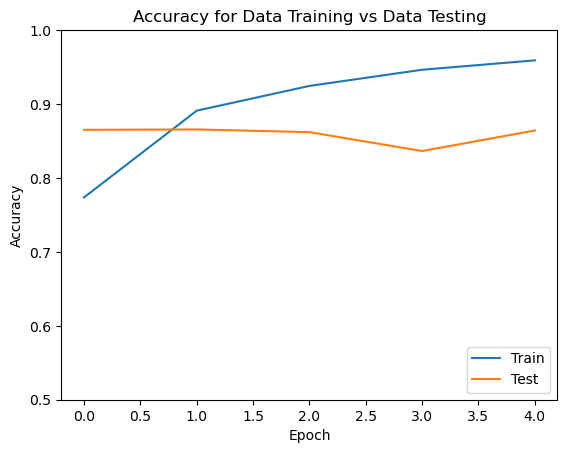

In [12]:
plt.title('Accuracy for Data Training vs Data Testing')
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], label = 'Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.5,1)
plt.legend(loc='lower right')

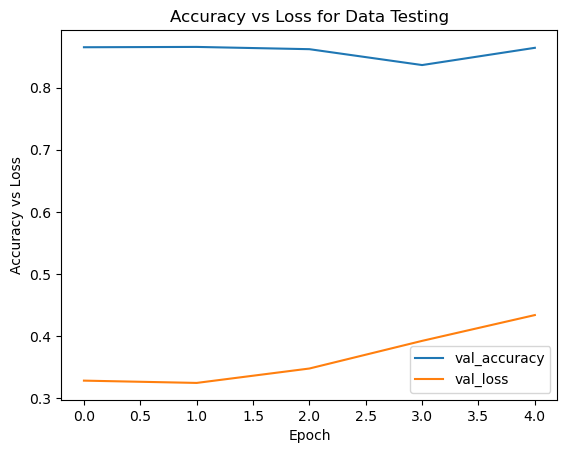

In [13]:
plt.title('Accuracy vs Loss for Data Testing')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy vs Loss')
plt.legend(loc='lower right')

Plot pertama menunjukkan bahwa akurasi data untuk data train dan data test semakin tinggi dan akurasinya lebih dari 80%. Pada plot kedua, nilai akurasi dan nilai loss berbanding terbalik. Jadi, berdasarkan kedua plot diatas dapat dikatakan bahwa tidak terdapat overfiting dan model layak digunakan untuk prediksi.

# Prediction

Kita perlu melakukan re-format data yang akan kita prediksi sentimennya menjadi format yang sama saat kita melatih data tersebut

In [16]:
# 6. Prediksi Sentimen untuk Review Baru
sample_review = "I love this movie! It was fantastic and really enjoyable."

# Tokenisasi review menjadi urutan kata-kata
sample_review = sample_review.lower().split()  # Mengubah teks menjadi daftar kata dan membuat semuanya kecil (lowercase)

# Mengonversi kata ke indeks menggunakan word_index
sample_review = [imdb.get_word_index().get(word, 0) for word in sample_review]  # Ganti kata dengan indeksnya, jika tidak ada, pakai 0

# Padding review agar panjangnya sama dengan input model
sample_review = pad_sequences([sample_review], maxlen=maxlen)

# Prediksi
prediction = model.predict(sample_review)
print(f"Prediksi Sentimen: {'Positif' if prediction[0] > 0.5 else 'Negatif'}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Prediksi Sentimen: Positif


# Reference
- https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data 